# Data Retrieval

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
import pandas as pd
import IPython.display
import matplotlib.pyplot as plt
import csv
import re
import numpy as np
from datetime import datetime
import statsmodels.api as sm

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [33]:
plt.style.use('seaborn')

In [3]:
# File path for cities: San Francisco(sf), Okaland(ok), Santa Clara(sc), 
# Santa Cruze(scz)

file_url = '/Users/xzhou/github/project_archives/files_airbnb/{}.csv'

sf_file = file_url.format('sf_airbnb/listings_details')
ok_file = file_url.format('ok_airbnb/listings_details')
sc_file = file_url.format('sc_airbnb/listings_details')
scz_file = file_url.format('scz_airbnb/listings_details')

In [4]:
# Loaded files as DataFrame

date_to_parse = ['last_scraped','host_since', 'first_review', 'last_review']

listings_sf = pd.read_csv(sf_file, parse_dates=date_to_parse)
listings_ok = pd.read_csv(ok_file, parse_dates=date_to_parse)
listings_sc = pd.read_csv(sc_file, parse_dates=date_to_parse)
listings_scz = pd.read_csv(scz_file, parse_dates=date_to_parse)

print('sf file dimensions: ', listings_sf.shape) 
print('ok file dimensions: ', listings_ok.shape) 
print('sc file dimensions: ', listings_sc.shape) 
print('scz file dimensions: ', listings_scz.shape) 

sf file dimensions:  (6633, 96)
ok file dimensions:  (2898, 96)
sc file dimensions:  (5668, 96)
scz file dimensions:  (1570, 96)


In [5]:
# Concatenated four files into one
# Created keys for each file for future references

frames = [listings_sf, listings_ok, listings_sc, listings_scz]
keys = ['sf', 'ok', 'sc', 'scz']

df_listings = pd.concat(frames, keys=keys)
df_listings.reset_index()

df_listings.head()

id                        listing_url     scrape_id last_scraped  \
sf 0   958   https://www.airbnb.com/rooms/958  2.018080e+13   2018-08-06   
   1  5858  https://www.airbnb.com/rooms/5858  2.018080e+13   2018-08-06   
   2  7918  https://www.airbnb.com/rooms/7918  2.018080e+13   2018-08-06   
   3  8142  https://www.airbnb.com/rooms/8142  2.018080e+13   2018-08-06   
   4  8339  https://www.airbnb.com/rooms/8339  2.018080e+13   2018-08-06   

                                                   name  \
sf 0                Bright, Modern Garden Unit - 1BR/1B   
   1                                 Creative Sanctuary   
   2         A Friendly Room - UCSF/USF - San Francisco   
   3  Friendly Room Apt. Style -UCSF/USF - San Franc...   
   4                    Historic Alamo Square Victorian   

                                                summary  \
sf 0  Our bright garden unit overlooks a grassy back...   
   1                                                NaN   
   2  Nice and good public transportation.  7 minute...   
   3  Nice and good public transportation.  7 minute...   
   4  Pls email before booking.  Interior featured i...   

                                                  space  \
sf 0  Newly remodeled, modern, and bright garden uni...   
   1  We live in a large Victorian house on a quiet ...   
   2  Room rental-sunny view room/sink/Wi Fi (inner ...   
   3  Room rental Sunny view Rm/Wi-Fi/TV/sink/large ...   
   4  Please send us a quick message before booking ...   

                                            description experiences_offered  \
sf 0  Our bright garden unit overlooks a grassy back...                none   
   1  We live in a large Victorian house on a quiet ...                none   
   2  Nice and good public transportation.  7 minute...                none   
   3  Nice and good public transportation.  7 minute...                none   
   4  Pls email before booking.  Interior featured i...                none   

                                  neighborhood_overview        ...          \
sf 0  *Quiet cul de sac in friendly neighborhood *St...        ...           
   1  I love how our neighborhood feels quiet but is...        ...           
   2  Shopping old town, restaurants, McDonald, Whol...        ...           
   3                                                NaN        ...           
   4                                                NaN        ...           

     requires_license      license jurisdiction_names instant_bookable  \
sf 0                t  STR-0001256  {"SAN FRANCISCO"}                f   
   1                t          NaN  {"SAN FRANCISCO"}                f   
   2                t          NaN  {"SAN FRANCISCO"}                f   
   3                t          NaN  {"SAN FRANCISCO"}                f   
   4                t  STR-0000264  {"SAN FRANCISCO"}                f   

     is_business_travel_ready          cancellation_policy  \
sf 0                        f                     moderate   
   1                        f  strict_14_with_grace_period   
   2                        f  strict_14_with_grace_period   
   3                        f  strict_14_with_grace_period   
   4                        f  strict_14_with_grace_period   

      require_guest_profile_picture require_guest_phone_verification  \
sf 0                              f                                f   
   1                              f                                f   
   2                              f                                f   
   3                              f                                f   
   4                              t                                t   

      calculated_host_listings_count  reviews_per_month  
sf 0                               1               1.38  
   1                               1               0.99  
   2                               9               0.16  
   3                               9               0.15  
 

In [6]:
# Added additional column to keep track of original district

df_listings['district'] = ''

df_listings.loc['sf']['district'] = 'San Francisco'
df_listings.loc['ok']['district'] = 'Oakland'
df_listings.loc['sc']['district'] = 'Santa Clara'
df_listings.loc['scz']['district'] = 'Santa Cruz'

In [7]:
# Created a separate dataframe to keep track of district
# The data frame will be used in later stage

df_district =  df_listings.loc[:, ['id', 'district']]
df_district.head()

id       district
sf 0   958  San Francisco
   1  5858  San Francisco
   2  7918  San Francisco
   3  8142  San Francisco
   4  8339  San Francisco

# Data Exploration

## Drill down to smaller set of features

In [8]:
# Checked for Null vales within data

display(df_listings.isnull().sum())

id                                      0
listing_url                             0
scrape_id                               0
last_scraped                            0
name                                    2
summary                               468
space                                3489
description                           124
experiences_offered                     0
neighborhood_overview                5398
notes                                7321
transit                              5550
access                               5261
interaction                          5880
house_rules                          4658
thumbnail_url                       16769
medium_url                          16769
picture_url                             0
xl_picture_url                      16769
host_id                                 0
host_url                                0
host_name                               0
host_since                              0
host_location                     

In [9]:
# Columns removed/dropped:
# Removed columns with >90% null values: 'experience_offered', 'host_acceptance_rate', 
#'neighbourhood_group_cleansed', 'square_feet'
# Removed 'jurisdiction_names', 'neighbourhood', kept'neighbourhood_cleansed'
# Noted'city' and 'smart location' provide duplicate information, removed 'smart location'
# Removed 'Country code' and 'country', as all instances locate within US


columns_to_keep =[
       'id','host_since','host_response_time', 'host_response_rate',
        'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 
       'host_has_profile_pic', 'host_identity_verified', 
        'neighbourhood_cleansed',
       'city', 
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type','amenities', 
       'price', 'security_deposit',
       'cleaning_fee', 'guests_included',  'minimum_nights','number_of_reviews',
       'first_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'jurisdiction_names', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month', 'district']


df_listings_smaller = df_listings[columns_to_keep]
display ('Dimensions after drilling down: ' ,df_listings_smaller.shape)
df_listings_smaller.head()

'Dimensions after clean up: '

(16769, 43)

id host_since  host_response_time host_response_rate  \
sf 0   958 2008-07-31      within an hour                92%   
   1  5858 2009-03-02      within an hour               100%   
   2  7918 2009-06-17  within a few hours               100%   
   3  8142 2009-06-17  within a few hours               100%   
   4  8339 2009-07-02      within an hour               100%   

     host_is_superhost  host_listings_count  host_total_listings_count  \
sf 0                 t                    1                          1   
   1                 f                    2                          2   
   2                 f                   10                         10   
   3                 f                   10                         10   
   4                 f                    2                          2   

     host_has_profile_pic host_identity_verified neighbourhood_cleansed  \
sf 0                    t                      t       Western Addition   
   1                    t                      t         Bernal Heights   
   2                    t                      t         Haight Ashbury   
   3                    t                      t         Haight Ashbury   
   4                    t                      t       Western Addition   

          ...       review_scores_value jurisdiction_names instant_bookable  \
sf 0      ...                      10.0  {"SAN FRANCISCO"}                f   
   1      ...                       9.0  {"SAN FRANCISCO"}                f   
   2      ...                       8.0  {"SAN FRANCISCO"}                f   
   3      ...                       9.0  {"SAN FRANCISCO"}                f   
   4      ...                      10.0  {"SAN FRANCISCO"}                f   

     is_business_travel_ready          cancellation_policy  \
sf 0                        f                     moderate   
   1                        f  strict_14_with_grace_period   
   2                        f  strict_14_with_grace_period   
   3                        f  strict_14_with_grace_period   
   4                        f  strict_14_with_grace_period   

      require_guest_profile_picture  require_guest_phone_verification  \
sf 0                              f                                 f   
   1                              f                                 f   
   2                              f                                 f   
   3                              f                                 f   
   4                              t                                 t   

      calculated_host_listings_count reviews_per_month       district  
sf 0                               1              1.38  San Francisco  
   1                               1              0.99  San Francisco  
   2                               9              0.16  San Francisco  
   3                               9              0.15  San Francisco  
   4                               2              0.24  San Francisco  

[5 rows x 43 columns]

## Format data appropriately

### Percentage

In [10]:
def apply2df(df, column_names, function):
    """
    This enables function to be applied to multiple columns of dataframe.
    Input: dataframe, columns to apply function to, function
    Return: updated dataframe
    """
    for column in column_names:
        df[column] = df[column].apply(lambda x: function(x))
    return df

In [11]:
# Noted columns with percentage information are formated as strings, 
# and need to convert to float

def percent2float(string):
    """
    Convert strings with percentage sign to float
    """
    percentage = float(str(string).strip('%'))/100.0
    return percentage

In [12]:
print ('Type: ', type(df_listings_smaller.host_response_rate[0]))
df_listings_smaller.host_response_rate[0:5]

<class 'str'>


sf  0     92%
    1    100%
    2    100%
    3    100%
    4    100%
Name: host_response_rate, dtype: object

In [13]:
# Converted percentage features to float

columns = ['host_response_rate']

df_listings_smaller = apply2df(df_listings_smaller, columns, percent2float)

In [14]:
df_listings_smaller.host_response_rate[0:5]

sf  0    0.92
    1    1.00
    2    1.00
    3    1.00
    4    1.00
Name: host_response_rate, dtype: float64

### Currency

In [15]:
# Noted columns with currency information are formated as strings, 
# and need to convert to float

def currency2float(string):
    """
    Convert currency to float
    """
    string = str(string).strip(' ').replace(' \\n', '')
    float_ = float(string.strip('$').replace(',',''))
    return float_

In [19]:
print ('Type of price: ', type(df_listings_smaller.price[0]))
display (df_listings_smaller.price[0:5])

print ('Type of security deposit: ', type(df_listings_smaller.security_deposit[0]))
display(df_listings_smaller.security_deposit[0:5])

print ('Type of security deposit: ', type(df_listings_smaller.cleaning_fee[0]))
display(df_listings_smaller.cleaning_fee[0:5])

Type of price:  <class 'str'>


sf  0    $170.00 
    1    $235.00 
    2     $65.00 
    3     $65.00 
    4    $675.00 
Name: price, dtype: object

Type of security deposit:  <class 'str'>


sf  0    $100.00 
    1         NaN
    2    $200.00 
    3    $200.00 
    4      $0.00 
Name: security_deposit, dtype: object

Type of security deposit:  <class 'str'>


sf  0    $100.00 
    1    $100.00 
    2     $50.00 
    3     $50.00 
    4    $225.00 
Name: cleaning_fee, dtype: object

In [20]:
# Converted currency features to float

columns = ['price', 'security_deposit', 'cleaning_fee']

df_listings_smaller = apply2df(df_listings_smaller, columns, currency2float)

### Timestamp

In [21]:
# This is to convert timestamp features to duration
# Duration is calculated by: 
# number of years between original timestamp and current year

def duration(starting_time):
    """
    Calculate duration or number of years between current year and starting_time
    """
    starting_year = starting_time.year
    current_year = datetime.now().year
    duration = current_year - starting_year + 1
    
    return duration

In [22]:
# Converted timestamp features to duration

columns = ['host_since', 'first_review']

df_listings_smaller = apply2df(df_listings_smaller, columns, duration)

In [23]:
mapper = {'host_since' : 'host_yrs', 'first_review': 'yrs_since_1st_review'}

df_listings_smaller.rename(columns=mapper, inplace=True)

In [25]:
df_listings_smaller.columns

Index(['id', 'host_yrs', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'city', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'minimum_nights', 'number_of_reviews',
       'yrs_since_1st_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'jurisdiction_names',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month', 'district'],
      dtype='obje

## Remove Outliers

In [26]:
df_listings_smaller.price.describe(percentiles=[.05, .10, .25, .50, .75, .90, .95])

count    16769.000000
mean       188.023555
std        274.564274
min          0.000000
5%          41.000000
10%         52.000000
25%         79.000000
50%        125.000000
75%        201.000000
90%        350.000000
95%        499.000000
max      10000.000000
Name: price, dtype: float64

In [34]:
# Removed outliers. Kept values between 5% and 95% percentiles

five_percentitle = np.percentile(df_listings_smaller['price'], 5)
ninety_five_percentitle = np.percentile(df_listings_smaller['price'], 95)

df_listings_smaller = df_listings_smaller[
                     (df_listings_smaller['price']<=ninety_five_percentitle) 
                      & (df_listings_smaller['price']>=five_percentitle)]

display(df_listings_smaller.shape)

(11248, 43)

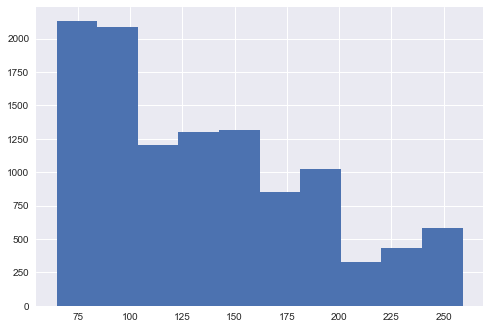

In [35]:
df_listings_smaller.price.hist()

## Handle null values

In [37]:
# Check for null values

df_listings_smaller.isnull().sum()

id                                     0
host_yrs                               0
host_response_time                  1312
host_response_rate                  1312
host_is_superhost                      0
host_listings_count                    0
host_total_listings_count              0
host_has_profile_pic                   0
host_identity_verified                 0
neighbourhood_cleansed                 0
city                                  12
is_location_exact                      0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                             14
bedrooms                               3
beds                                   7
bed_type                               0
amenities                              0
price                                  0
security_deposit                    2744
cleaning_fee                        1487
guests_included                        0
minimum_nights  

In [38]:
# Filled null values with average for security deposits and cleaning fee

df_listings_smaller['security_deposit'].fillna(
                    value=df_listings_smaller['security_deposit'].mean(),
                    inplace=True)

df_listings_smaller['cleaning_fee'].fillna(
                    value=df_listings_smaller['cleaning_fee'].mean(),
                    inplace=True)

In [ ]:
# Noted 'security deposit', 'minimum nights' can vary considerably among postings 
# Converted them to boolean variables

df_listings_smaller['security_deposit'] = (df_listings_smaller['security_deposit']>0) \
                                          .astype(int)

df_listings_smaller['minimum_nights'] = (df_listings_smaller['minimum_nights']>1)  \
                                        .astype(int)

In [39]:
df_listings_smaller.isnull().sum()

id                                     0
host_yrs                               0
host_response_time                  1312
host_response_rate                  1312
host_is_superhost                      0
host_listings_count                    0
host_total_listings_count              0
host_has_profile_pic                   0
host_identity_verified                 0
neighbourhood_cleansed                 0
city                                  12
is_location_exact                      0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                             14
bedrooms                               3
beds                                   7
bed_type                               0
amenities                              0
price                                  0
security_deposit                       0
cleaning_fee                           0
guests_included                        0
minimum_nights  

In [43]:
# Dropped remaining null values

df_listings_clean = df_listings_smaller.dropna()

display('Dimensions after dropping null values: ', df_listings_clean.shape)
df_listings_clean.isnull().sum()

'Dimensions after dropping null values: '

(7559, 43)

id                                  0
host_yrs                            0
host_response_time                  0
host_response_rate                  0
host_is_superhost                   0
host_listings_count                 0
host_total_listings_count           0
host_has_profile_pic                0
host_identity_verified              0
neighbourhood_cleansed              0
city                                0
is_location_exact                   0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
amenities                           0
price                               0
security_deposit                    0
cleaning_fee                        0
guests_included                     0
minimum_nights                      0
number_of_reviews                   0
yrs_since_1s

In [41]:
df_listings_cleaned.columns

Index(['id', 'host_yrs', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'city', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'minimum_nights', 'number_of_reviews',
       'yrs_since_1st_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'jurisdiction_names',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month', 'district'],
      dtype='obje

In [44]:
# Created a separate dataframe to keep track of juristiction info
# The df will be used in later stage

df_jur = df_listings_clean.loc[:, ['id', 'jurisdiction_names']]

## Handle categorical data

## Convert list of amenities to features

In [ ]:
# Removed special characters within Amenities

df_listings_smaller['jurisdiction_names'] = df_listings_smaller['jurisdiction_names'].str.replace('[^\w\s,]', '')
df_listings_smaller['amenities'] = df_listings_smaller['amenities'].str.replace('[^\w\s,]', '')

In [ ]:
# Converted list of amenities to a dataframe

display ('Original list of amenities: ', df_listings_smaller.amenities.head())

df_amenities = df_listings_smaller  \
               .amenities  \
               .str.get_dummies(sep = ",")  \
               .add_prefix('amenities_')

print('df_ammenities dimension: ', df_amenities.shape)
display(df_amenities.head())

In [ ]:
# There are 100+ types of amenities. 
# This is to filter down to common owned amenities.

common_amenities = []

for column in df_amenities.columns:
    value = df_amenities[column].quantile(0.75)
    if value > 0:
        common_amenities.append(column)

df_common_amenities = df_amenities[common_amenities]

display (common_amenities)
display (df_common_amenities.head())

In [ ]:
# Added common amenities dataframe to original dataframe
# Drop original amenties columns, which is a list of amenities

df_listings_refined = pd.concat([df_smaller_listings, df_common_amenities], axis=1)

df_listings_refined.drop('amenities', axis=1, inplace=True)
df_listings_refined.columns

In [ ]:
# Selected all non-numeric variables and converted to dummy varialbes

categorical_variables = df_listings_cleaned.select_dtypes(include=['object']).columns
df_model = pd.get_dummies(data=df_listings_cleaned,columns=categorical_variables)

display(df_listings_cleaned[categorical_variables].head())
print('Dimension after converted categorical features to dummy values: ', df_model.shape)

## Handle features with high correlation

In [ ]:
# Identified features with high correlations, and dropped accordingly

# Created correlation matrix
corr_matrix = df_model.corr().abs()

# Selected upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Identified index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

display (to_drop)

# Dropped features with high corrleation 
df_model.drop(columns = to_drop, inplace = True)
display('Dimension after drop high correlated fetures', df_model.shape)

In [ ]:
# Stored the complete set of features

pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'

pkl_file_name = pkl_file.format('all_listings')

df_model.to_pickle(pkl_file_name)

# Modeling

## Feature normalization and train, test splits

In [ ]:
# Performed quick regression models to get a big picture of performance, 
# and prepare for feature slections

X = df_model.drop(['id','price'], axis=1)
y = df_model['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state=42)

In [ ]:
# Normalize features 

ss = StandardScaler()
X_train_trans = ss.fit_transform(X_train)
X_test_trans = ss.transform (X_test)

## Linear Regression

In [ ]:
model = sm.OLS(y_train, sm.add_constant(X_train_trans))
fit = model.fit()
fit.summary()

## Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train_trans, y_train)
y_train_pred = rf.predict(X_train_trans)
y_test_pred = rf.predict(X_test_trans)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

## Feature selection

In [ ]:
# Sorted feature by importance

feature_labels = X.columns
feature_tuples = zip (feature_labels, rf.feature_importances_)
feature_lists = [list(feature_tuple) for feature_tuple in feature_tuples]

feature_lists.sort(key=lambda x: abs(x[1]), reverse=True)

display (feature_lists)

In [ ]:
# Kept features that are above 0.001 thresold

features_selected = [feature for feature, importance in feature_lists
                    if importance >= 0.001]

nums_features_selected = len(features_selected)

print ('Number of features kept: ', nums_features_selected)
display(feature_lists[0:nums_features_selected])

## Random Forest with slected features

In [ ]:
# Perform another model(Random Forest) based on selected features

X_updated = df_model[features_selected]
y_updated = df_model['price']

In [ ]:
X_updated_train, X_updated_test, y_updated_train, y_updated_test = train_test_split(
    X_updated, y_updated, test_size =0.3, random_state=42)

In [ ]:
ssX2 = StandardScaler()
X_updated_train_trans = ssX2.fit_transform(X_updated_train)
X_updated_test_trans = ssX2.transform (X_updated_test)

In [ ]:
rf_updated = RandomForestRegressor(n_estimators=500, 
                                   criterion='mse', 
                                   random_state=3, 
                                   n_jobs=-1)
rf_updated.fit(X_updated_train_trans, y_updated_train)
y_updated_train_pred = rf_updated.predict(X_updated_train_trans)
y_updated_test_pred = rf_updated.predict(X_updated_test_trans)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_updated_train, y_updated_train_pred),
        mean_squared_error(y_updated_test, y_updated_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_updated_train, y_updated_train_pred),
        r2_score(y_updated_test, y_updated_test_pred)))

In [ ]:
# Kept 'id', and all selected features

columns =['id'] + features_selected
df_listings_top_features = df_model[columns]
df_listings_top_features.head()

In [ ]:
# Added District and jurisdiction informaiton for future use

df_listings_top_features = pd.merge(left=df_listings_top_features, 
                                    right=df_district, 
                                    how ='left', 
                                    left_on='id',
                                    right_on='id')


df_listings_top_features = pd.merge(left=df_listings_top_features, 
                                    right=df_jurisdiction, 
                                    how ='left', 
                                    left_on='id',
                                    right_on='id')


# Renamed columns used for furture reference to avoid confusion

df_listings_top_features.rename(columns={'district':'ref_district',
                                        'jurisdiction_names': 'ref_jurisdiction'},
                               inplace=True)
df_listings_top_features

In [ ]:
# Checked for null values before data storage

df_listings_top_features.isnull().sum()

# Data storage

In [ ]:
# Stored data post feature selection

pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'

pkl_path = pkl_file.format('listings_post_feature_selection')

df_listings_top_features.to_pickle(pkl_path)